# ccdt_afig_BehAndModel

### This notebook generates figures related for

Figure 1:  Foreperiod delay task measures anticipatory and endogoenous response variability
a) task schematic
b) example RT distributions - 179
c) model:
- left - rise to bound process on short delay
- middle - anticipatory process
- right - modulated rise to bound process on long delay  (including false alarms)
- 3 related processes - anticipation, prestim bias, poststim bias
d) Group level RT difference
e) RSquared 

built from ccdt_explore_beh_model_dynamicBaseline
    
Ashwin G. Ramayya (ashwinramayya@gmail.com)
10/16/23
 
    
    

In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
from sklearn.metrics import r2_score,pairwise_distances
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 20
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/afig_BehAndModel/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
def clean_fig(apply_int=True,apply_int_x = True, apply_int_y = True):
    plt.gca().set_yticks(np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],3))
    plt.gca().set_xticks(np.linspace(plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],3))
    if apply_int==True:
        if apply_int_y == True:
            plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'),fontsize=20)
        else:
            plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=20)     
        if apply_int_x == True:
            plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
        else:
            plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=20)
    else:
        plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=20)
        plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=20)


GB = cc.GroupBehavior()


def getBehData(S):
    
    # collect error and fast response rate
    choiceEv = S.ev_df.query('type=="RESPONSE"')
    evQuery_correct = 'error==0&fastResponse==0'
    
    fp_dict={}
    fp_dict['subj'] = S.subj
    fp_dict['n_trials'] = len(choiceEv)
    fp_dict['n_sess'] = len(np.unique(choiceEv['session']))
    fp_dict['mean_rt'] = np.mean(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    fp_dict['std_rt'] = np.std(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    
    fp_dict['mean_rtL'] = np.mean(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['std_rtL'] = np.std(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['mean_rtS'] = np.mean(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    fp_dict['std_rtS'] = np.std(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    
    
    # rt diff
    fp_dict['rtDiff_mean'] = fp_dict['mean_rtL'] - fp_dict['mean_rtS']
    fp_dict['rtDiff_std'] = fp_dict['std_rtL'] - fp_dict['std_rtS']
    
    
    fp_dict['error_rate'] = (np.sum(choiceEv.eval('RT<0'))/len(choiceEv))
    fp_dict['error_rateS'] = (np.sum(choiceEv.eval('RT<0&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['error_rateL'] = (np.sum(choiceEv.eval('RT<0&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['error_diff'] = fp_dict['error_rateL'] - fp_dict['error_rateS']
    
    fp_dict['lapse_rate'] = (np.sum(choiceEv.eval('RT>=1000'))/len(choiceEv))
    fp_dict['lapse_rateS'] = (np.sum(choiceEv.eval('RT>=1000&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['lapse_rateL'] = (np.sum(choiceEv.eval('RT>=1000&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['lapse_diff'] = fp_dict['lapse_rateL'] - fp_dict['lapse_rateS']
    
    # fit LATER2
    rts_A,rts_B,pred_idx_A,pred_idx_B = S.getRTs_for_LATER2()

    # FIT LATER 2
    #fp_dict.update(S.fitLATER2_byCondition(rts_A,rts_B,pred_idx_A, pred_idx_B,model_type = 'std_bias'))
    
    return fp_dict


In [ ]:
#plot timing of each trial onset
S = cc.Subject('HUP179')

sess_ev_s1 = S.ev_df.query('session=="Session_1"&type=="FIX_START"')
sess_ev_r = S.ev_df.query('session=="Session_1"&type=="RESPONSE"')

for i in np.arange(0,len(sess_ev_s1)):
    # time elapsed from prior response
    time_elapsed_s = (sess_ev_s1.iloc[i]['mstime']-sess_ev_r.iloc[i-1]['mstime'])/1000
    print(time_elapsed_s)

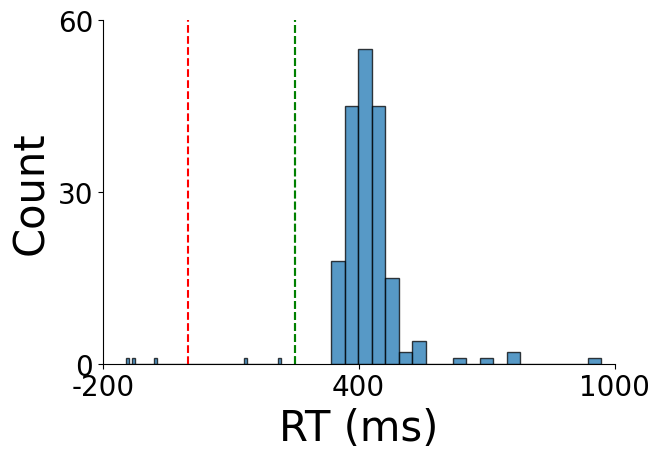

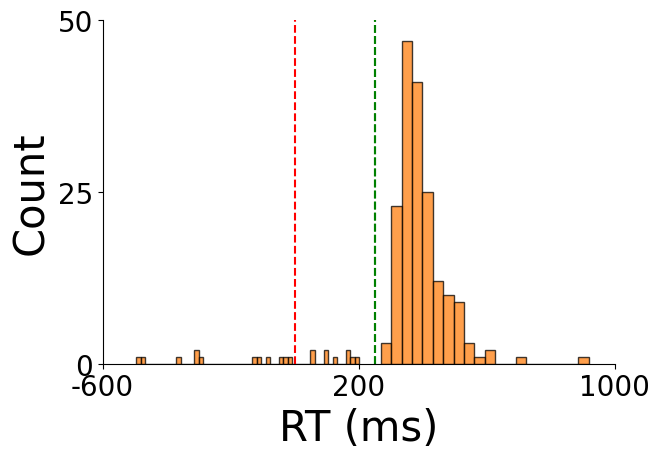

In [2]:
# example RTs
# SUBJECT 179

S = cc.Subject('HUP179')
subj_dict = getBehData(S)
f = plt.figure(figsize=(7,5))
ax = plt.subplot(111)

# plot short delay (correct)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C0',
     alpha = .75,
     bins = 20)

ax.vlines((250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('green'))


# plot anticipatory false alarms
S.plotRT(ax = ax,evQuery='RT<250&RT>-500&delay==500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C0',
     alpha = .75,
     bins = 50)
ax.set_ylabel('count',fontsize=30)
ax.set_xlabel('RT (ms)',fontsize=30)
S.set_axes_rt(ax=plt.gca(),plot_type = 'standard',add_legend=False)
ax.vlines((0,250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('red','green'))
clean_fig()
#plt.gca().text(500,30,'$\Delta$ mean RT \n     $=$ \n'+str(np.round(subj_dict['rtDiff_mean'],2))+' ms',fontsize=20)
#plt.gca().text(-550,30,'anticipatory \nfalse alarm \nrate = '+str((subj_dict['error_rate']*100).astype('int'))+' %',fontsize=20)
save_fig('egRT_HUP179--SHORT')

f = plt.figure(figsize=(7,5))
ax = plt.subplot(111)

# plot short delay (correct)
S.plotRT(ax = ax,evQuery='error==0&fastResponse==0&delay==1500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C1',
     alpha = .75,
     bins = 20)

ax.vlines((250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('green'))


# plot anticipatory false alarms
S.plotRT(ax = ax,evQuery='RT<250&RT>-500&delay==1500',\
     plot_type='standard',
     plot_median=False,
     yL=None,
     model_type='mean_std',color ='C1',
     alpha = .75,
     bins = 50)
ax.set_ylabel('count',fontsize=30)
ax.set_xlabel('RT (ms)',fontsize=30)
S.set_axes_rt(ax=plt.gca(),plot_type = 'standard',add_legend=False)
ax.vlines((0,250),ax.get_ylim()[0],ax.get_ylim()[1],linestyle='--',color=('red','green'))
clean_fig()
#plt.gca().text(500,30,'$\Delta$ mean RT \n     $=$ \n'+str(np.round(subj_dict['rtDiff_mean'],2))+' ms',fontsize=20)
#plt.gca().text(-550,30,'anticipatory \nfalse alarm \nrate = '+str((subj_dict['error_rate']*100).astype('int'))+' %',fontsize=20)

save_fig('egRT_HUP179--LONG')

/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


HUP133
HUP136


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


HUP139
HUP140
HUP142


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


HUP143
HUP145
HUP146
HUP150
HUP152
HUP153


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


HUP154
HUP157


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


HUP160
HUP165


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


HUP168
HUP171
HUP178
HUP179
HUP181
HUP182


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:2525: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f,ax = plt.subplots(2,2,figsize=(5,5))
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


HUP187
HUP191


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_30575/892810402.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']


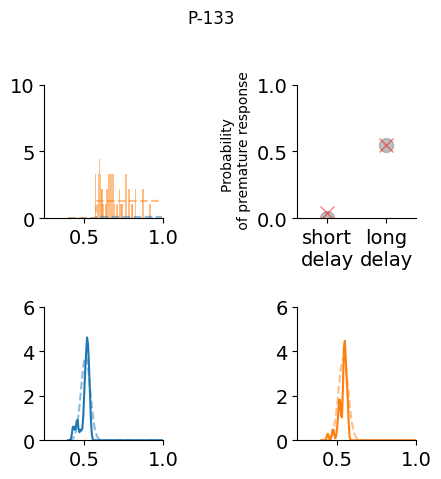

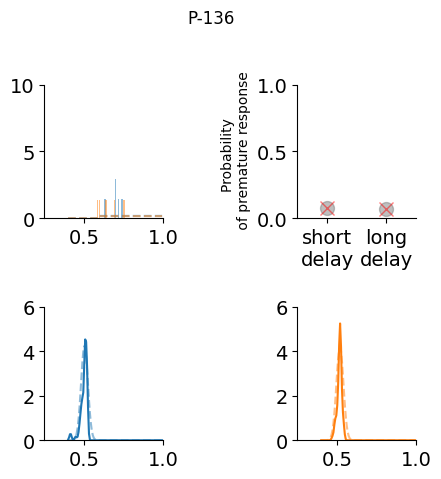

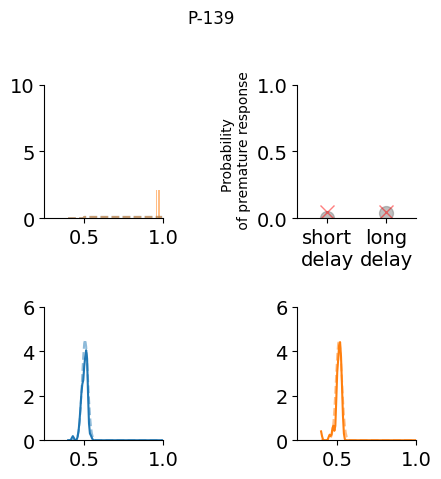

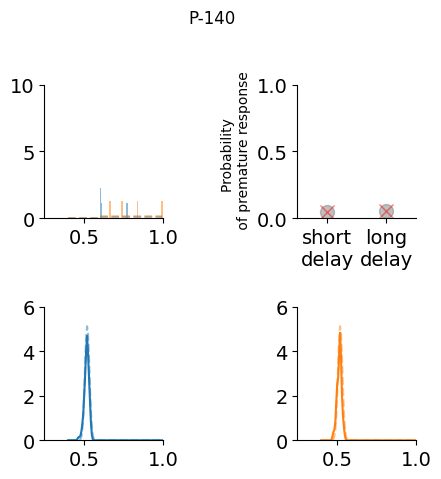

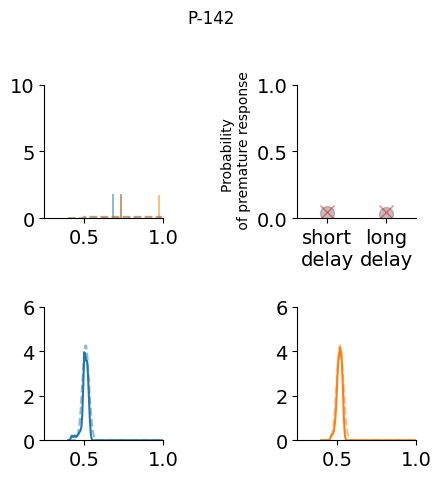

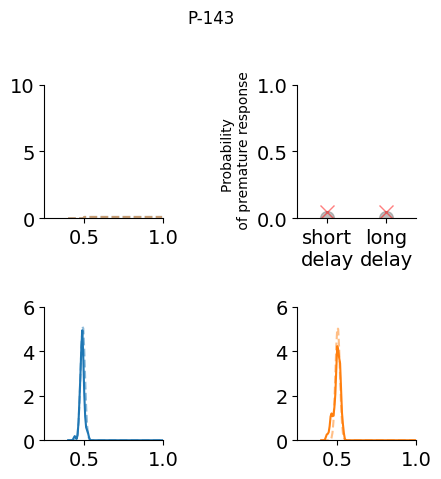

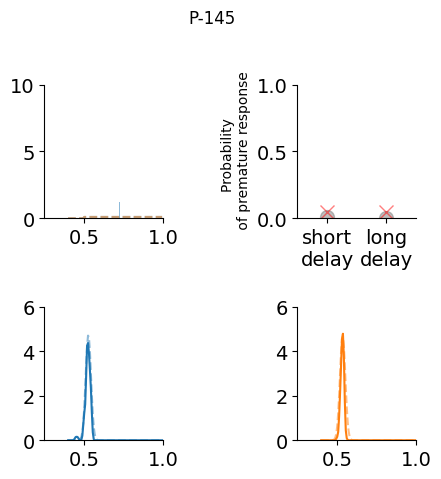

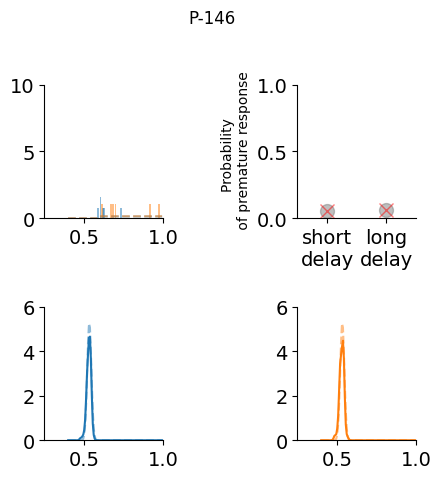

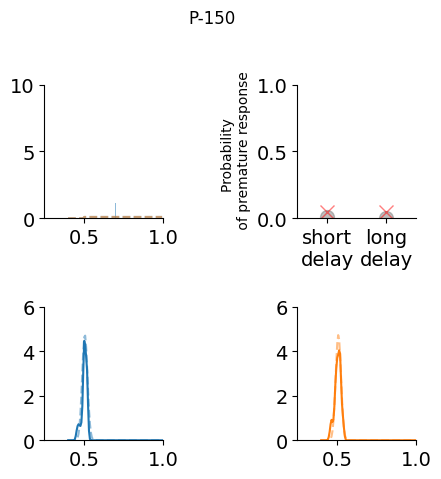

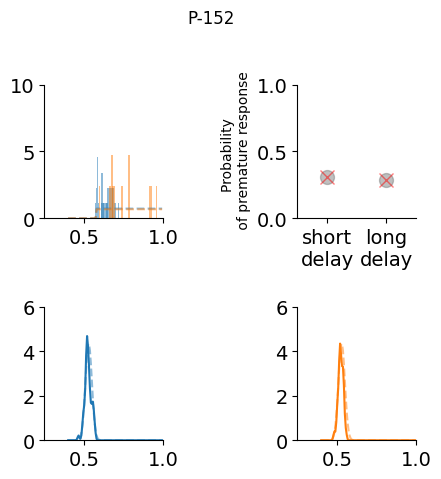

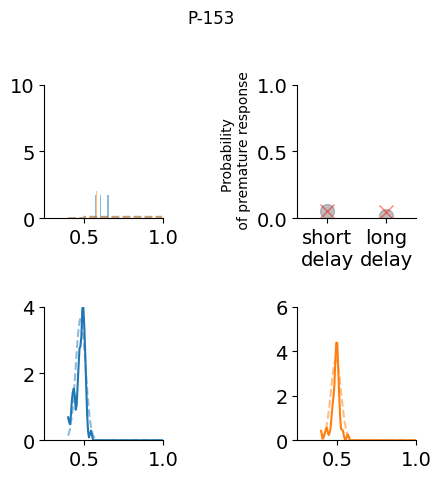

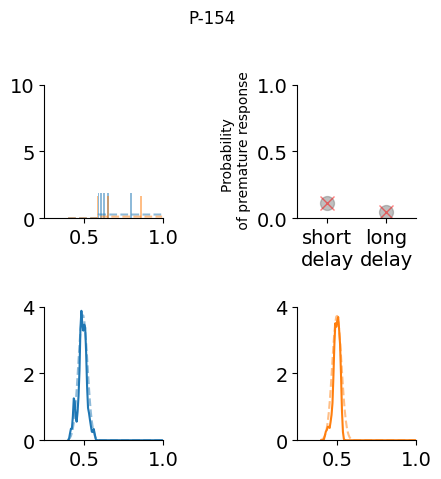

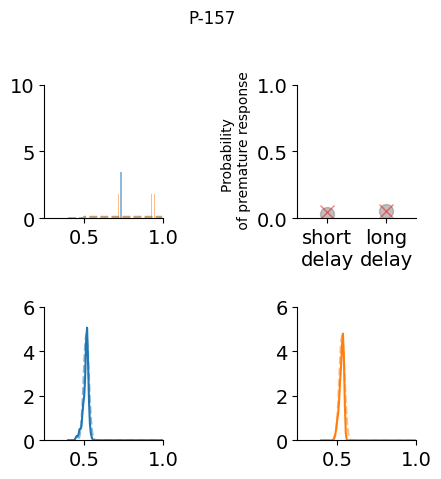

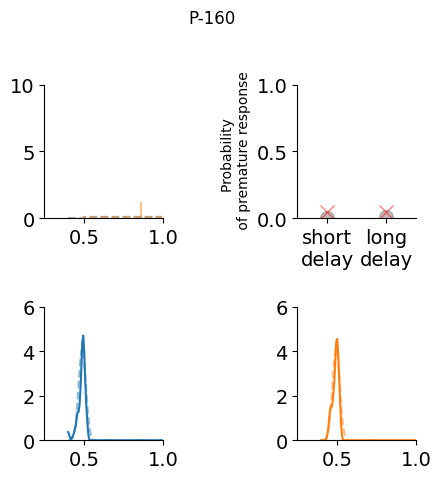

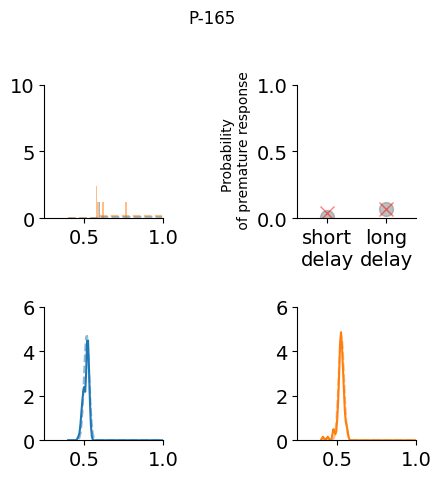

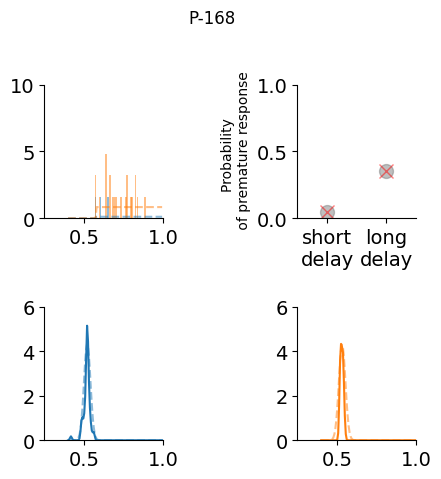

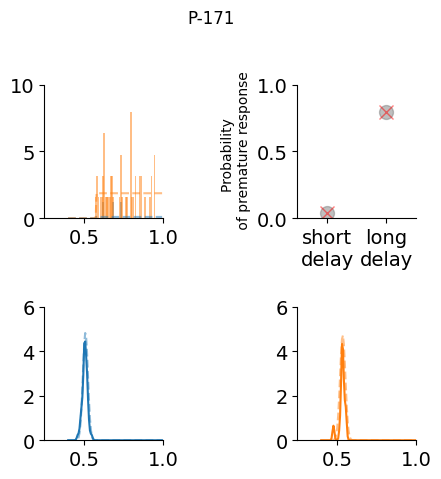

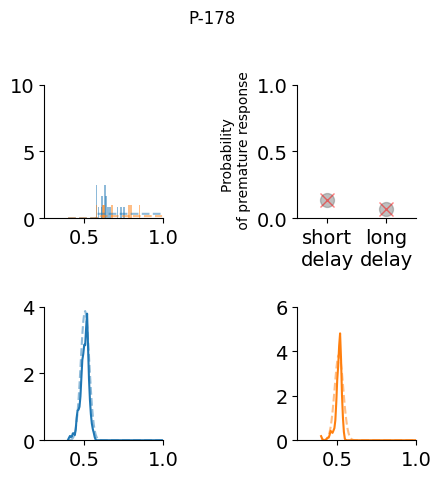

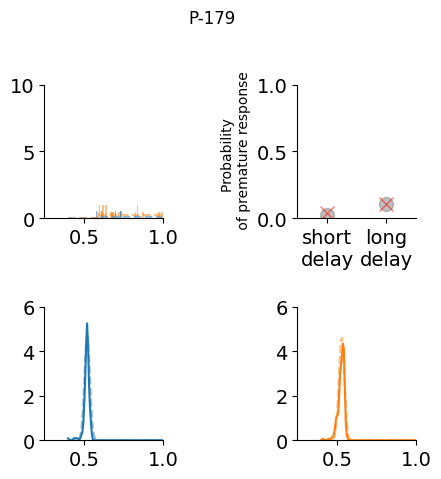

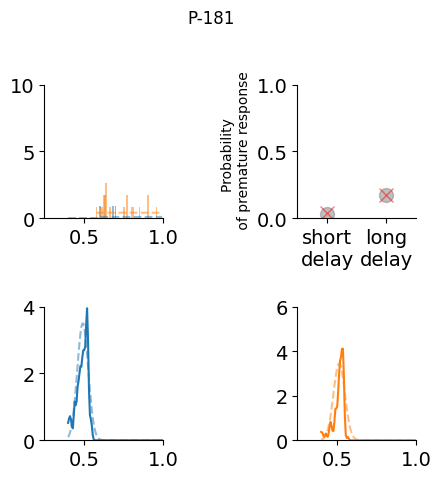

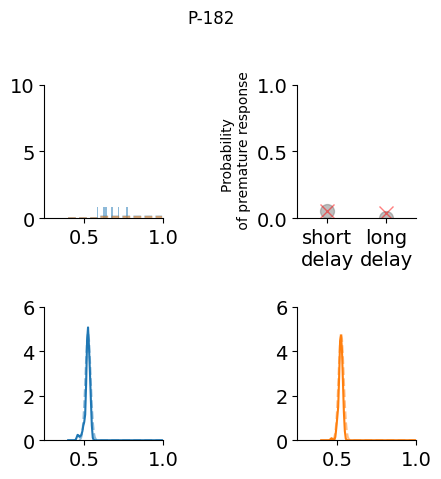

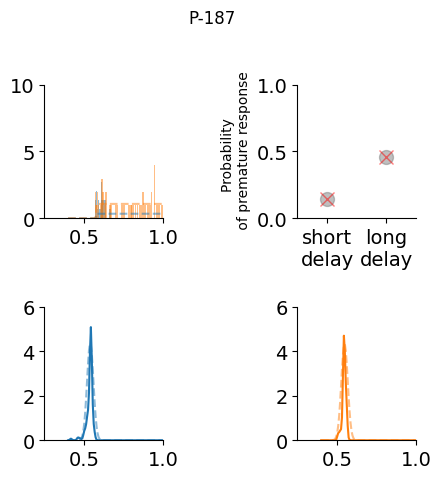

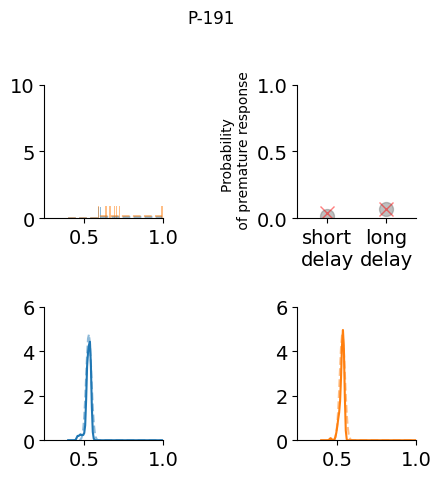

In [3]:
# collect data for all subjects

#%%capture
# collect param_df
fp_dict_list = []
evQuery_correct = 'error==0&fastResponse==0'
evQuery_raw = 'error==0'
for s in np.arange(0,len(GB.subj_list)):
    
    # initialize Subject
    S = cc.Subject(subj = GB.subj_list[s]) 
    
    # collect error and fast response rate
    choiceEv = S.ev_df.query('type=="RESPONSE"')
    
    fp_dict={}
    fp_dict['subj'] = S.subj
    fp_dict['n_trials'] = len(choiceEv)
    fp_dict['n_sess'] = len(np.unique(choiceEv['session']))
    fp_dict['mean_rt'] = np.mean(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    fp_dict['std_rt'] = np.std(choiceEv.query(evQuery_correct)['RT'].to_numpy())
    
    fp_dict['mean_rtL'] = np.mean(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['std_rtL'] = np.std(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())
    fp_dict['iqr_rtL'] = stats.iqr(choiceEv.query(evQuery_correct+'&delay==1500')['RT'].to_numpy())

    fp_dict['mean_rtS'] = np.mean(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    fp_dict['std_rtS'] = np.std(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    fp_dict['iqr_rtS'] = stats.iqr(choiceEv.query(evQuery_correct+'&delay==500')['RT'].to_numpy())
    
    fp_dict['mean_rtRawL'] = np.mean(choiceEv.query(evQuery_raw+'&delay==1500')['RT'].to_numpy())
    
    fp_dict['mean_rtRawS'] = np.mean(choiceEv.query(evQuery_raw+'&delay==500')['RT'].to_numpy())
    
    
    # rt diff
    fp_dict['rtDiff_mean'] = fp_dict['mean_rtL'] - fp_dict['mean_rtS']
    fp_dict['rtDiff_std'] = fp_dict['std_rtL'] - fp_dict['std_rtS']
    fp_dict['rtDiffRaw_mean'] = fp_dict['mean_rtRawL'] - fp_dict['mean_rtRawS']
    
    
    fp_dict['error_rate'] = (np.sum(choiceEv.eval('RT<0'))/len(choiceEv))
    fp_dict['error_rateS'] = (np.sum(choiceEv.eval('RT<0&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['error_rateL'] = (np.sum(choiceEv.eval('RT<0&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['error_diff'] = fp_dict['error_rateL'] - fp_dict['error_rateS']
    fp_dict['error_diff_ratio'] = fp_dict['error_rateL']/fp_dict['error_rateS']
    
    
    fp_dict['lapse_rate'] = (np.sum(choiceEv.eval('RT>=1000'))/len(choiceEv))
    fp_dict['lapse_rateS'] = (np.sum(choiceEv.eval('RT>=1000&delay==500'))/np.sum(choiceEv.eval('delay==500')))
    fp_dict['lapse_rateL'] = (np.sum(choiceEv.eval('RT>=1000&delay==1500'))/np.sum(choiceEv.eval('delay==1500')))
    fp_dict['lapse_diff'] = fp_dict['lapse_rateL'] - fp_dict['lapse_rateS']
    
    # fit LATER2
    rts_A,rts_B,pred_idx_A,pred_idx_B = S.getRTs_for_LATER2()

    # FIT LATER 2
    #fp_dict.update(S.fitLATER2_byCondition(rts_A,rts_B,pred_idx_A, pred_idx_B,\
    #                                       model_type = 'std_bias',\
    #                                       modeling_strategy='weighted',plot_fit=True,r2_smoothing_factor=1))#model_type = 'mean_bias'
    
    # fit LATER2 -race
    fp_dict.update(S.fitLATER2_byCondition(rts_A,rts_B,pred_idx_A, pred_idx_B,\
                                           model_type = 'distance',\
                                           modeling_strategy='DynamicBaseline',plot_fit=True,r2_smoothing_factor=1))#model_type = 'mean_bias'
    
    #
    plt.gcf().suptitle('P-'+S.subj.split('HUP')[-1],fontsize=12)
    save_fig('ModelFit-'+S.subj)
    # update list
    fp_dict_list.append(fp_dict)

    print(S.subj)
    
    
# get data frame
fp_df = pd.DataFrame(fp_dict_list) 

### check R squared

0.8543787487886982
0.619062949712355
0.9671313461314028
21
0


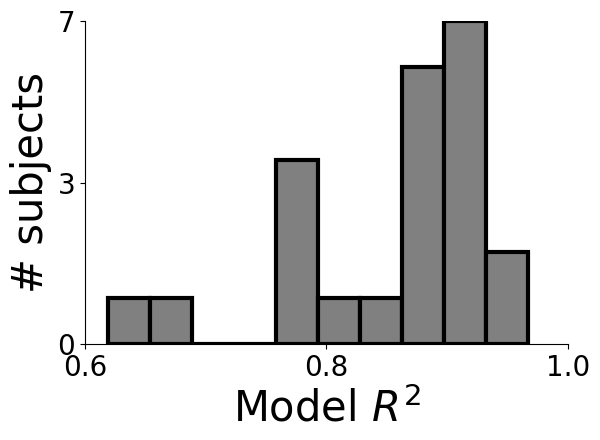

In [8]:
f = plt.figure()
plt.hist(fp_df['rsquared'].to_numpy(),color = '0.5',linewidth=3,edgecolor = 'k');
plt.gca().set_xlabel('Model $R^{2}$',fontsize=30)
plt.gca().set_ylabel('# subjects',fontsize=30)
clean_fig(apply_int=False)
plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'))

save_fig('r2_dist_fullModel')

print(np.mean(fp_df['rsquared'].to_numpy()))
print(np.min(fp_df['rsquared'].to_numpy()))
print(np.max(fp_df['rsquared'].to_numpy()))
print(np.sum(fp_df['rsquared'].to_numpy()>0.75))
print(np.sum(fp_df['rsquared'].to_numpy()<=0.5))

0.8584737449106258
0.6217372663865812
0.9691334697539967
.............


0.7666865827413499
0.3668473535363648
0.9696415822347558


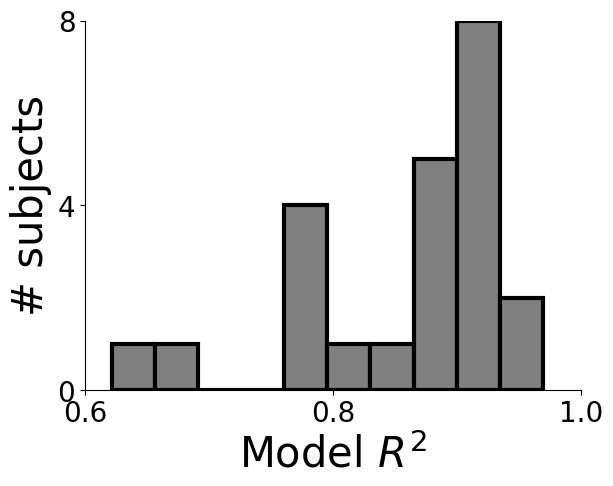

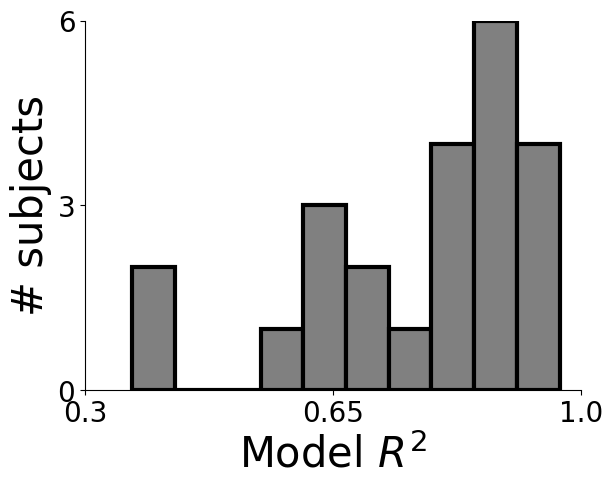

In [9]:
# alternative models
altmod_mean_dict_list = []
altmod_std_dict_list = [] 
evQuery_correct = 'error==0&fastResponse==0'
evQuery_raw = 'error==0'
for s in np.arange(0,len(GB.subj_list)):
    
    alt_dict_mean={}
    alt_dict_std={}
    
    # initialize Subject
    S = cc.Subject(subj = GB.subj_list[s]) 
    
   
    rts_A,rts_B,pred_idx_A,pred_idx_B = S.getRTs_for_LATER2()

    # fit LATER2 - mean
    alt_dict_mean.update(S.fitLATER2_byCondition(rts_A,rts_B,pred_idx_A, pred_idx_B,\
                                           model_type = 'mean',\
                                           modeling_strategy='DynamicBaseline',plot_fit=False,r2_smoothing_factor=1))#model_type = 'mean_bias'
    altmod_mean_dict_list.append(alt_dict_mean)
    
    # fit LATER2 - std
    alt_dict_std.update(S.fitLATER2_byCondition(rts_A,rts_B,pred_idx_A, pred_idx_B,\
                                           model_type = 'std',\
                                           modeling_strategy='DynamicBaseline',plot_fit=False,r2_smoothing_factor=1))#model_type = 'mean_bias'
    altmod_std_dict_list.append(alt_dict_std)
    
    
# get data frame
altmod_mean_df = pd.DataFrame(altmod_mean_dict_list) 
altmod_std_df = pd.DataFrame(altmod_std_dict_list) 

def plotR2(mod_df):
    print(np.mean(mod_df['rsquared'].to_numpy()))
    print(np.min(mod_df['rsquared'].to_numpy()))
    print(np.max(mod_df['rsquared'].to_numpy()))
    f = plt.figure()
    plt.hist(mod_df['rsquared'].to_numpy(),color = '0.5',linewidth=3,edgecolor = 'k');
    plt.gca().set_xlabel('Model $R^{2}$',fontsize=30)
    plt.gca().set_ylabel('# subjects',fontsize=30)
    clean_fig(apply_int=False)
    plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'))
plotR2(altmod_mean_df)
print('.............\n\n')
plotR2(altmod_std_df)


### Here we correlate model parameters with with delay-related behavior

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)


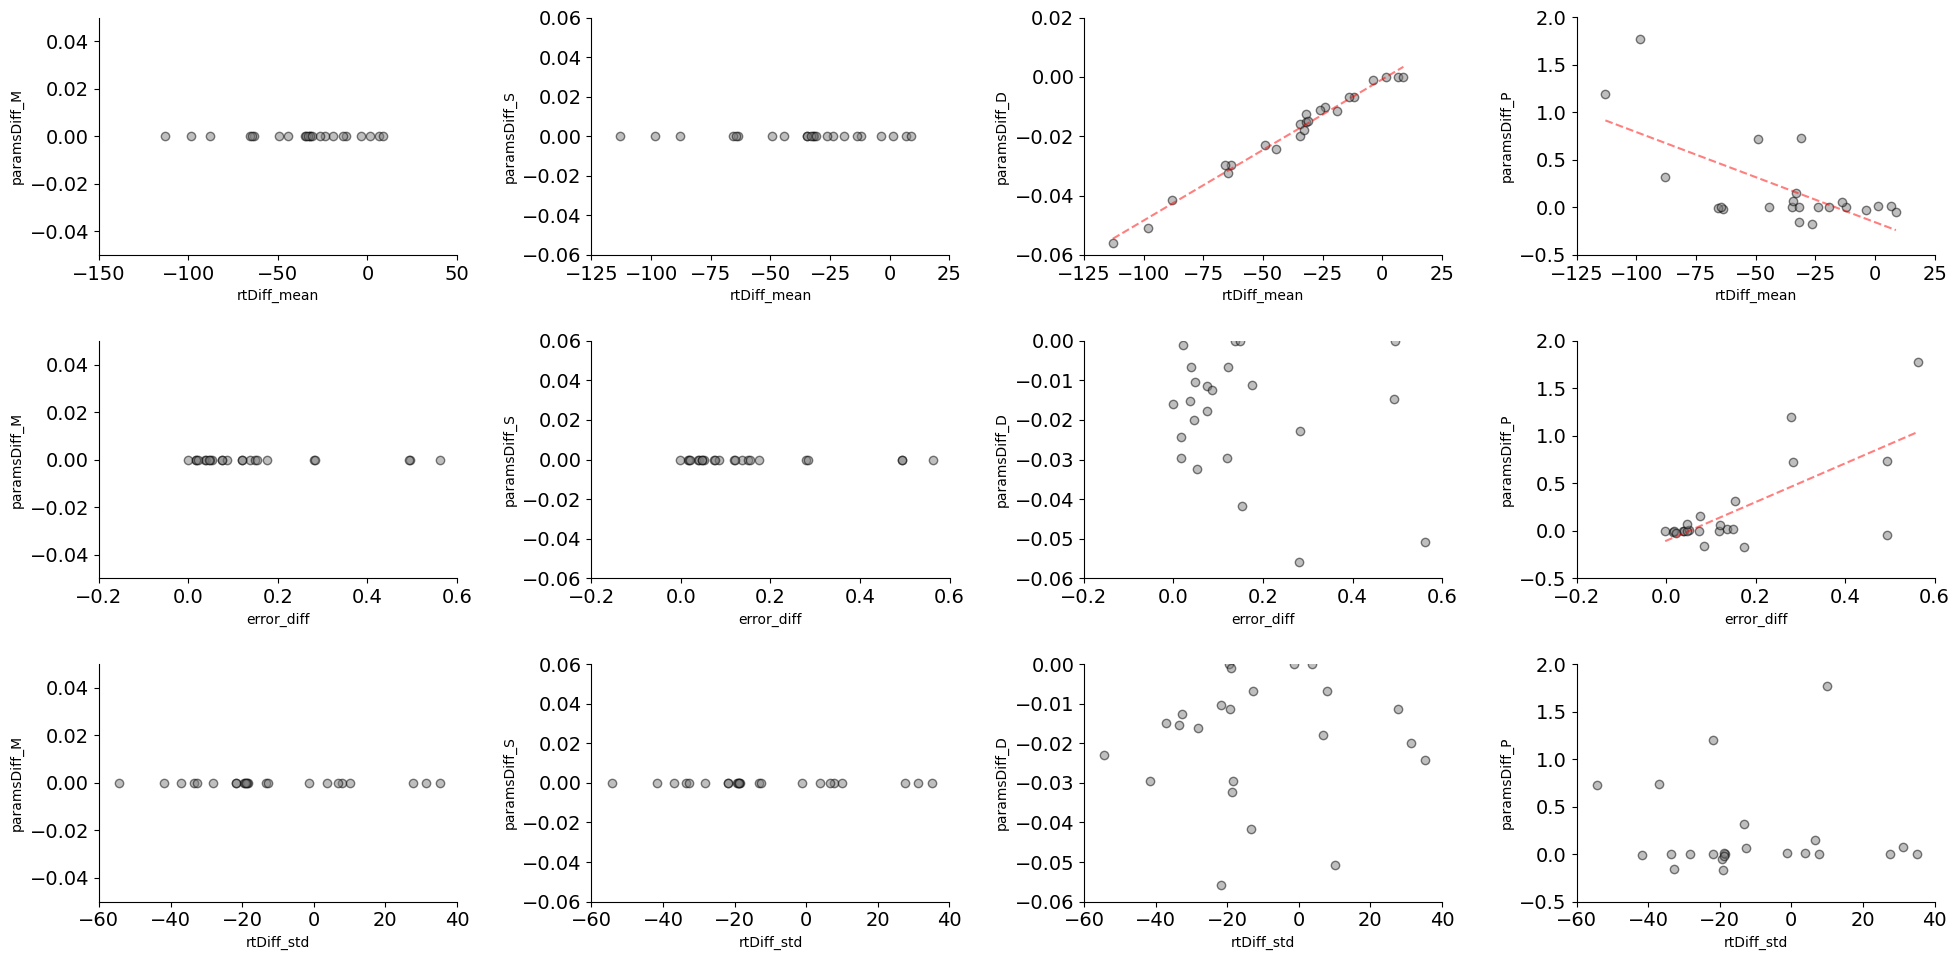

In [4]:
#  params list (LATER 2)
#params_list = ['paramsDiff_B','paramsDiff_S']

# params list (RACE)
params_list = ['paramsDiff_M','paramsDiff_S','paramsDiff_D','paramsDiff_P'] #paramsDiff_uS,'paramsDiff_uS_ratio']


# make subplots

f,ax = plt.subplots(3,len(params_list),figsize=(20,10))

#ax[0,1].set_title('test')

for p in params_list:
    
    # plot rtdiff
    S.plot_scatter(fp_df['rtDiff_mean'],fp_df[p],ax = ax[0,params_list.index(p)])
    ax[0,params_list.index(p)].set_title('')
    ax[0,params_list.index(p)].set_xlabel('rtDiff_mean',fontsize=10)
    ax[0,params_list.index(p)].set_ylabel(p,fontsize=10)
    #ax[0,params_list.index(p)].axis('tight')
    
    # plot false alarm
    S.plot_scatter(fp_df['error_diff'],fp_df[p],ax = ax[1,params_list.index(p)]) #error_diff_ratio
    ax[1,params_list.index(p)].set_title('')
    ax[1,params_list.index(p)].set_xlabel('error_diff',fontsize=10)
    ax[1,params_list.index(p)].set_ylabel(p,fontsize=10)
    #ax[1,params_list.index(p)].axis('tight')

    
    # plot false alarm
    S.plot_scatter(fp_df['rtDiff_std'],fp_df[p],ax = ax[2,params_list.index(p)])
    ax[2,params_list.index(p)].set_title('')
    ax[2,params_list.index(p)].set_xlabel('rtDiff_std',fontsize=10)
    ax[2,params_list.index(p)].set_ylabel(p,fontsize=10)
    #ax[1,params_list.index(p)].axis('tight')
    
    save_fig('modelparams-vs-beh')

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)


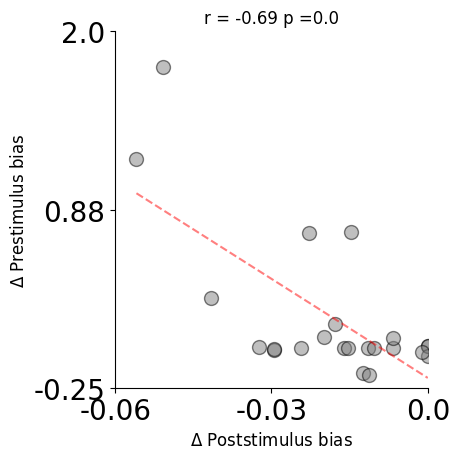

In [5]:
### Here we plot the across-subject correlation between each model parameter 


remove_zeros=False
param_lbl_1 = 'D' # 'D' - distance
param_lbl_2 = 'P' # 'P' - premature response probability


# scatter plot summarizing model (no colors)
S.plot_scatter(fp_df['paramsDiff_'+param_lbl_1].to_numpy(),fp_df['paramsDiff_'+param_lbl_2].to_numpy(),plotLine=True, \
               remove_zeros=remove_zeros,s=100,alpha=0.5,figsize=(5,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()
#cb = plt.colorbar(pad = 0.1,fraction = 0.05)
#plt.clim(0,1)
#cb.set_label('$\Delta$ false alarm rate',fontsize=20)
#cb.ax.tick_params(labelsize=20)
#plt.gca().set_xlim((-0.04,0.04))
clean_fig(apply_int=False)
plt.gca().set_xlabel('$\Delta$ Poststimulus bias',fontsize=12)
plt.gca().set_ylabel('$\Delta$ Prestimulus bias',fontsize=12)
save_fig('modelparams-correlation')


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)


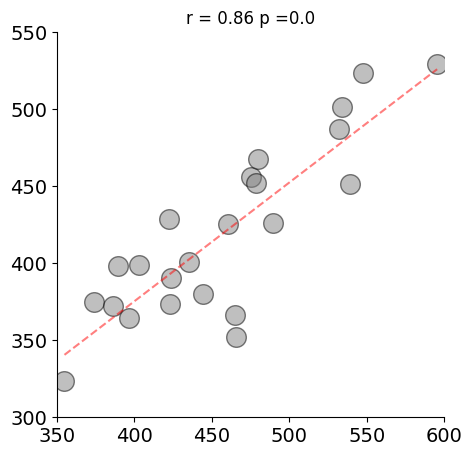

In [9]:
S.plot_scatter(fp_df['mean_rtS'].to_numpy(),fp_df['mean_rtL'].to_numpy(),plotLine=True, \
               remove_zeros=remove_zeros,s=200,alpha=0.5,figsize=(5,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)


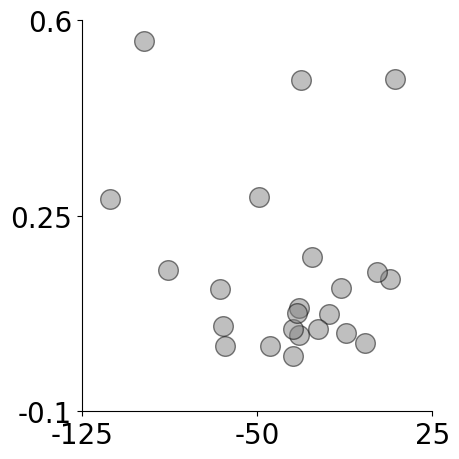

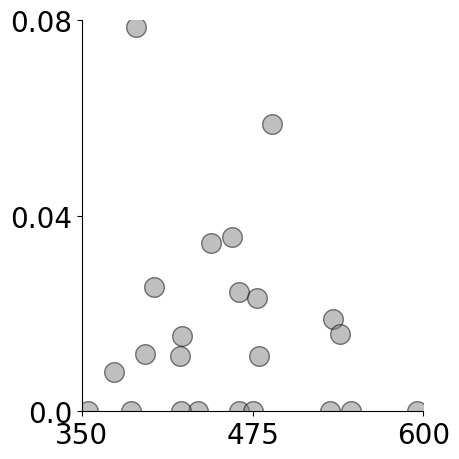

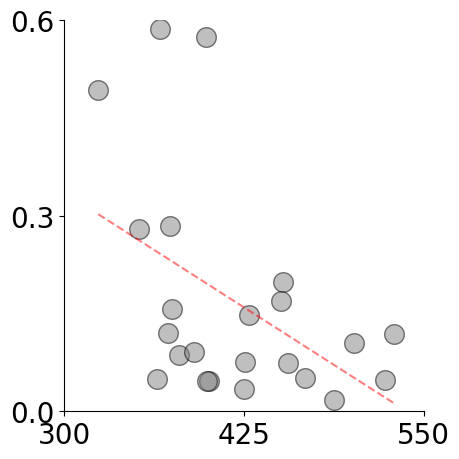

In [8]:
remove_zeros=False
param_lbl_1 = 'D' # 'D' - distance
param_lbl_2 = 'P' # 'P' - premature response probability

# scatter plot summarizing model (no colors)
S.plot_scatter(fp_df['rtDiff_mean'].to_numpy(),fp_df['error_diff'].to_numpy(),plotLine=True, \
               remove_zeros=remove_zeros,s=200,alpha=0.5,figsize=(5,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()
#cb = plt.colorbar(pad = 0.1,fraction = 0.05)
#plt.clim(0,1)
#cb.set_label('$\Delta$ false alarm rate',fontsize=20)
#cb.ax.tick_params(labelsize=20)
#plt.gca().set_xlim((-0.04,0.04)
plt.gca().set_title('')
clean_fig(apply_int=True,apply_int_y=False)
#plt.gca().set_xlabel('$\Delta$ RT',fontsize=12)
#plt.gca().set_ylabel('$\Delta$ False alarm rate',fontsize=12)
save_fig('beh-correlation')



# scatter plot summarizing model (no colors)
S.plot_scatter(fp_df['mean_rtS'].to_numpy(),fp_df['error_rateS'].to_numpy(),plotLine=True, \
               remove_zeros=remove_zeros,s=200,alpha=0.5,figsize=(5,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()
#cb = plt.colorbar(pad = 0.1,fraction = 0.05)
#plt.clim(0,1)
#cb.set_label('$\Delta$ false alarm rate',fontsize=20)
#cb.ax.tick_params(labelsize=20)
#plt.gca().set_xlim((-0.04,0.04)
plt.gca().set_title('')
clean_fig(apply_int=True,apply_int_y=False)
#plt.gca().set_xlabel('$\Delta$ RT',fontsize=12)
#plt.gca().set_ylabel('$\Delta$ False alarm rate',fontsize=12)
save_fig('beh-correlationS')


# scatter plot summarizing model (no colors)
S.plot_scatter(fp_df['mean_rtL'].to_numpy(),fp_df['error_rateL'].to_numpy(),plotLine=True, \
               remove_zeros=remove_zeros,s=200,alpha=0.5,figsize=(5,5),edgecolor='k');#text_lbls=fp_df['subj'].to_numpy()

plt.gca().set_title('')
#cb = plt.colorbar(pad = 0.1,fraction = 0.05)
#plt.clim(0,1)
#cb.set_label('$\Delta$ false alarm rate',fontsize=20)
#cb.ax.tick_params(labelsize=20)
#plt.gca().set_xlim((-0.04,0.04))
clean_fig(apply_int=True,apply_int_y=False)
#plt.gca().set_xlabel('$\Delta$ RT',fontsize=12)
#plt.gca().set_ylabel('$\Delta$ False alarm rate',fontsize=12)
save_fig('beh-correlationL')

# Stats

In [14]:
# Stats for average delay related behavior
res = stats.ttest_1samp(fp_df['mean_rtL']-fp_df['mean_rtS'],popmean=0)
print(res)
print(fp_df['mean_rtL'].shape[0]-1)

res = stats.ttest_1samp(fp_df['error_rateL']-fp_df['error_rateS'],popmean=0)
print(res)
print(fp_df['error_rateL'].shape[0]-1)

r,p= stats.pearsonr(fp_df['rtDiff_mean'],fp_df['error_diff'])
print(r,p)

r,p= stats.pearsonr(fp_df['mean_rtL'],fp_df['error_rateL'])
print(r,p)

Ttest_1sampResult(statistic=-5.5735667715150425, pvalue=1.3298674086567066e-05)
22
Ttest_1sampResult(statistic=4.429193072974043, pvalue=0.00021145586978270277)
22
-0.201245517804672 0.3571617057443781
-0.47082221143532066 0.02335875240266092
